In [56]:
import numpy as np 
import pandas as pd 
import csv
import os
import re

for dirname, _, filenames in os.walk('/CSC172/K Means Project/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
data = pd.read_csv('SPAM_SMS.csv')

In [2]:

# Focus only on the 'text' column, drop the other columns
data = data[['text']]

# Data Cleaning
# Normalize Text: Convert all text to lowercase
data['text'] = data['text'].str.lower()

# Remove Punctuation
data['text'] = data['text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

# Strip Extra Spaces
data['text'] = data['text'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())

# Save the cleaned data to a new file
data.to_csv('initial_cleaned.csv', index=False)

print("Data cleaning completed and saved as 'initial_cleaned.csv'")


Data cleaning completed and saved as 'initial_cleaned.csv'


In [57]:
import spacy
import pandas as pd

# Load the SpaCy model
nlp = spacy.load("en_core_web_sm")

# Load your dataset
data = pd.read_csv('initial_cleaned.csv')

# Load and clean stopword files
with open('english-stopwords.txt', 'r') as file:
    english_stopwords = set(word.strip().lower() for word in file.readlines())

with open('genediazjr-tagalog.txt', 'r') as file:
    filipino_stopwords = set(word.strip().lower() for word in file.readlines())

# Combine English and Filipino stopwords
stopwords_combined = english_stopwords.union(filipino_stopwords)

# Preprocess text
def preprocess_text(text):
    # Tokenize and remove stopwords
    doc = nlp(text)
    tokens = [token.text.lower() for token in doc if token.text.lower() not in stopwords_combined and token.is_alpha]
    return " ".join(tokens)  # Join tokens back into a string if needed

# Apply preprocessing
data['stopwords_removed'] = data['text'].apply(preprocess_text)

# Save the processed data
data.to_csv('stopwords_removed.csv', index=False)
print("Processed data saved as 'stopwords_removed.csv'")


Processed data saved as 'stopwords_removed.csv'


In [58]:
# Load English word list from nltk or a local file
import nltk
nltk.download('words')
from nltk.corpus import words
english_words = set(words.words())

# Load Tagalog word list
with open('Filipino-wordlist.txt', 'r', encoding='utf-8') as file:
    tagalog_words = set(word.strip().lower() for word in file.readlines())

# Combine English and Tagalog word lists
valid_words = english_words.union(tagalog_words)

[nltk_data] Downloading package words to D:\Documents\4th year
[nltk_data]     files\CSC172\K Means Project\.venv\Lib\site-
[nltk_data]     packages\nltk...
[nltk_data]   Package words is already up-to-date!


In [59]:
def preprocess_text(text):
    # Tokenize and filter out invalid words
    doc = nlp(text)
    tokens = [
        token.text.lower() 
        for token in doc 
        if token.is_alpha and token.text.lower() in valid_words
    ]
    
    # Remove duplicated words while keeping the first occurrence
    unique_tokens = []
    seen = set()
    for token in tokens:
        if token not in seen:
            unique_tokens.append(token)
            seen.add(token)
    
    return " ".join(unique_tokens)

# Apply preprocessing
data['cleaned_text'] = data['stopwords_removed'].apply(preprocess_text)

# Save the cleaned data
data.to_csv('processed_filtered_data.csv', index=False)
print("Processed data with valid words and no duplicates saved as 'processed_filtered_data.csv'")

Processed data with valid words and no duplicates saved as 'processed_filtered_data.csv'


In [60]:
print(data['cleaned_text'].head())

0    new green township rising south maple grove fi...
1    new office space sale ortigas avenue near grov...
2    celebrate season love sweet intimate dinner tw...
3    shangrila updates residential commercial devel...
4    co makati needs software java developer knowle...
Name: cleaned_text, dtype: object


In [11]:
pf = pd.read_csv("D:/Documents/4th year files/CSC172/K Means Project/processed_filtered_data.csv", index_col=0, quoting=csv.QUOTE_NONNUMERIC, encoding="utf-8")

In [40]:
from ydata_profiling import ProfileReport
ProfileReport(pf)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [12]:
# Strip leading/trailing whitespace and replace any non-printable characters
pf['cleaned_text'] = pf['cleaned_text'].replace({r'[\r\n\t]': ''}, regex=True).str.strip()

# Drop rows with NaN or empty strings again
pf = pf.dropna(subset=['cleaned_text'])
pf = pf[pf['cleaned_text'].str.strip() != '']

# Verify
print(pf['cleaned_text'].str.strip().eq('').sum())  # Should output 0


0


In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as sch

data_path = "processed_filtered_data.csv"  # Update with your actual file path
df = pd.read_csv(data_path)

In [4]:
# Step 1: Vectorize text using TF-IDF
vectorizer = CountVectorizer()   # Adjust features as needed
X =  vectorizer.fit_transform(df['cleaned_text'])

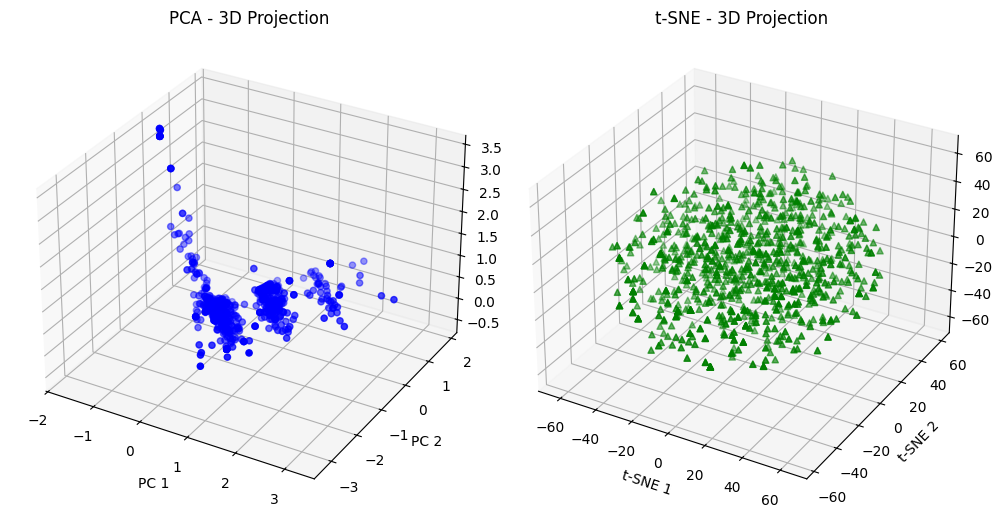

In [16]:

# Agglomerative Clustering
k = 3  # Choose number of clusters
agg_clustering = AgglomerativeClustering(n_clusters=k)
labels = agg_clustering.fit_predict(X.toarray())  # Convert sparse to dense matrix here

# PCA for Dimensionality Reduction to 3D
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X.toarray())  # Convert sparse to dense matrix here

# Plotting PCA 3D Visualization
fig = plt.figure(figsize=(10, 8))

# PCA plot
ax = fig.add_subplot(121, projection='3d')
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c='blue', marker='o')
ax.set_title('PCA - 3D Projection')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')

# t-SNE for 3D Visualization
tsne = TSNE(n_components=3)
X_tsne = tsne.fit_transform(X.toarray())  # Convert sparse to dense matrix here

# Plotting t-SNE 3D Visualization
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], c='green', marker='^')
ax2.set_title('t-SNE - 3D Projection')
ax2.set_xlabel('t-SNE 1')
ax2.set_ylabel('t-SNE 2')
ax2.set_zlabel('t-SNE 3')

plt.tight_layout()
plt.show()


k-means


Cluster 0:
free, get, deposit, win, bonus, daily, rewards, receive, log, highest

Cluster 1:
account, libreng, please, makakuha, cash, magparehistro, number, tumaya, oro, de

Cluster 2:
raffle, ticket, bonus, name, makuha, ba, swerte, nakuha, pindutin, punta

Cluster 3:
win, name, real, pesos, big, play, join, small, daily, bonus

Cluster 4:
bonus, win, get, free, new, join, enjoy, claim, big, payday

Cluster 5:
get, recharge, every, day, roulette, om, lucky, sign, gcash, draw

Cluster 6:
web, events, claim, celebrate, cup, world, baraha, last, days, big

Cluster 7:
bonus, makakuha, website, tangkilikin, trusted, sumali, magdeposito, limitadong, ibang, abala

Cluster 8:
near, village, alabang, clubhouse, across, years, presentation, subdivision, send, lots

Cluster 9:
number, maglagay, upang, natanggap, valid, hrs, cs, within, credit, nalagay

Cluster 10:
buy, solar, take, pwede, wall, market, pinaka, parking, outside, school

Cluster 11:
gcash, claim, cash, thank, user, team, receive

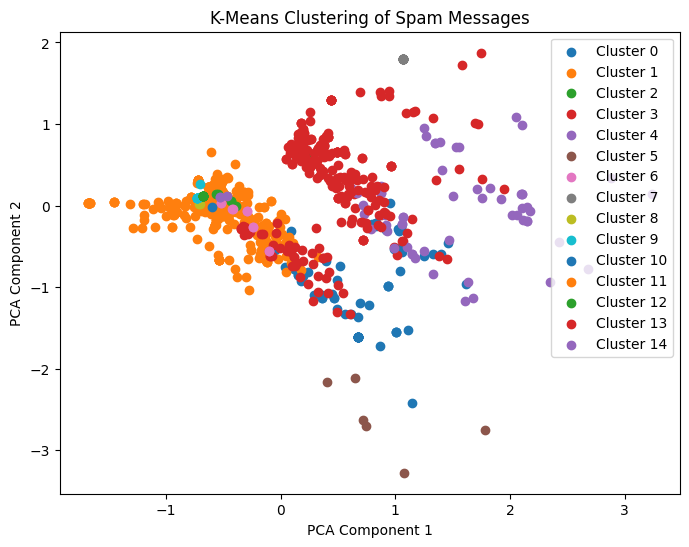

In [67]:


# Step 2: K-Means Clustering
n_clusters = 15  # Number of topics/clusters (adjust based on your dataset and goal)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X)

# Assign cluster labels to each text
df['Cluster'] = kmeans.labels_

# Step 3: Top terms per cluster
def print_top_terms_per_cluster(kmeans_model, vectorizer, n_terms=10):
    terms = vectorizer.get_feature_names_out()
    for i in range(kmeans_model.n_clusters):
        print(f"\nCluster {i}:")
        cluster_center = kmeans_model.cluster_centers_[i]
        top_terms = cluster_center.argsort()[-n_terms:][::-1]
        print(", ".join(terms[top_terms]))

print_top_terms_per_cluster(kmeans, vectorizer)

# Step 4: Visualize clusters using PCA (optional)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

plt.figure(figsize=(8, 6))
for cluster in range(n_clusters):
    plt.scatter(
        X_pca[df['Cluster'] == cluster, 0], 
        X_pca[df['Cluster'] == cluster, 1], 
        label=f"Cluster {cluster}"
    )
plt.title("K-Means Clustering of Spam Messages")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()


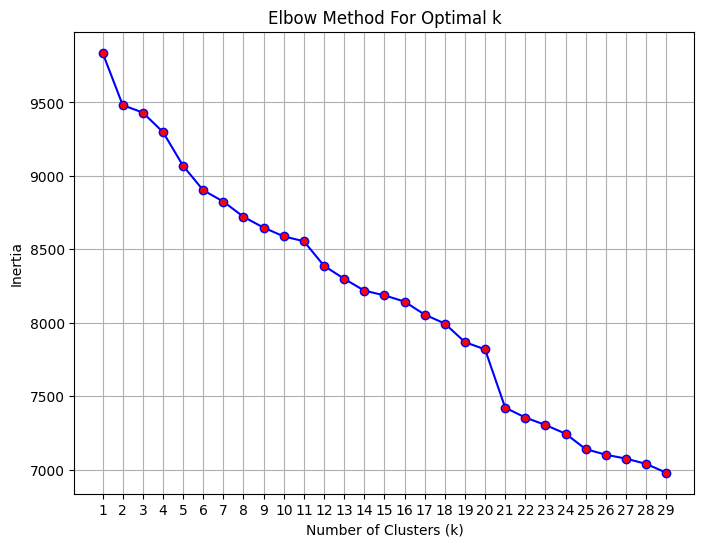

In [55]:
# 3. Apply K-means clustering and calculate inertia for different k values
inertia = []

# Increase the range of k values to test
k_range = range(1, 30)  # Testing k values from 1 to 20

# Apply K-means clustering for each value of k and calculate inertia
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)  # Fit on scaled data
    inertia.append(kmeans.inertia_)

# Plot the Elbow curve with improved appearance
plt.figure(figsize=(8, 6))
plt.plot(k_range, inertia, marker='o', linestyle='-', color='b', markerfacecolor='red')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_range)  # Ensure every k value is marked on the x-axis
plt.grid(True)
plt.show()


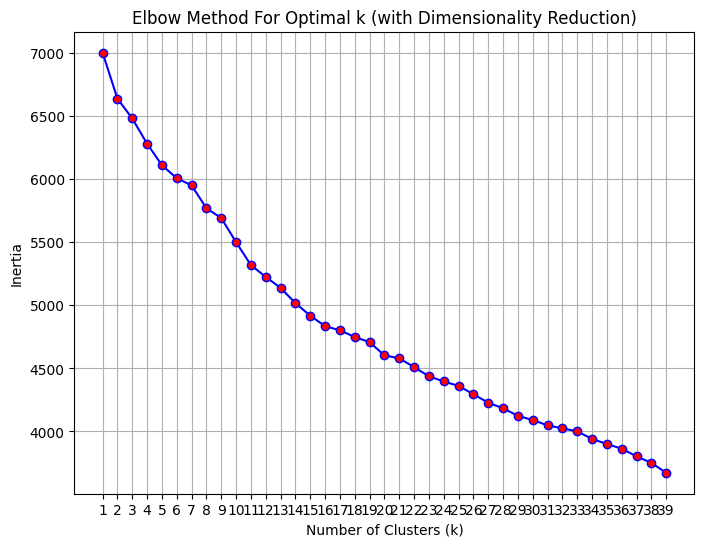

In [68]:
from sklearn.decomposition import TruncatedSVD

# 2. Apply Truncated SVD (Dimensionality Reduction)
svd = TruncatedSVD(n_components=100, random_state=42)  # Reducing to 100 components
X_reduced = svd.fit_transform(X)

# 3. Apply K-means clustering and calculate inertia for different k values
inertia = []

# Increase the range of k values to test
k_range = range(1, 40)  # Testing k values from 1 to 20

# Apply K-means clustering for each value of k and calculate inertia
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_reduced)  # Fit on reduced data
    inertia.append(kmeans.inertia_)

# Plot the Elbow curve with improved appearance
plt.figure(figsize=(8, 6))
plt.plot(k_range, inertia, marker='o', linestyle='-', color='b', markerfacecolor='red')
plt.title('Elbow Method For Optimal k (with Dimensionality Reduction)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_range)  # Ensure every k value is marked on the x-axis
plt.grid(True)
plt.show()


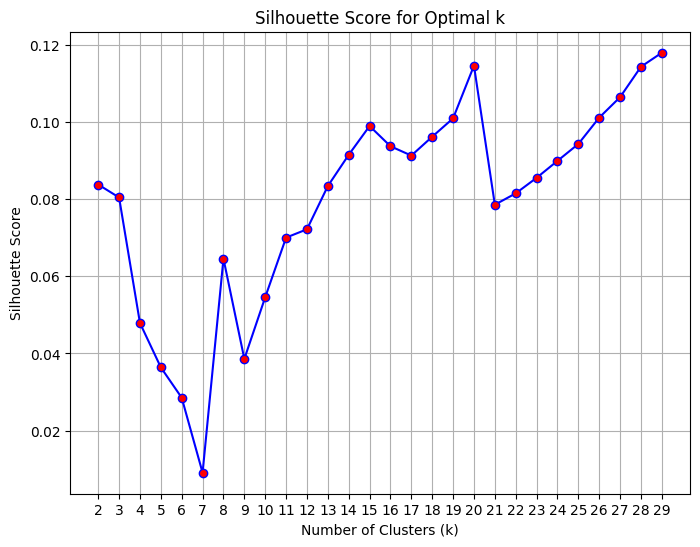

In [ ]:

import matplotlib.pyplot as plt

silhouette_scores = []
k_range = range(2, 30)  # Set the range from 2 to 20 (inclusive)

# Apply K-means clustering for each value of k and calculate silhouette scores
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_reduced)  # Fit on reduced data
    score = silhouette_score(X_reduced, kmeans.labels_)
    silhouette_scores.append(score)

# Plot the silhouette scores
plt.figure(figsize=(8, 6))
plt.plot(k_range, silhouette_scores, marker='o', linestyle='-', color='b', markerfacecolor='red')
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_range)  # Ensure every k value is marked on the x-axis
plt.grid(True)
plt.show()

hierarchical clustering


In [61]:
import pandas as pd
data = pd.read_csv('processed_filtered_data.csv')  # Replace with the correct file path
print(data.head())


                                                text  \
0  a new and green township will be rising in the...   
1  new office space for sale in ortigas avenue ne...   
2  celebrate the season of love with a sweet stay...   
3  shangrila updates risemakati oneofakind reside...   
4  co in makati needs software java developer kno...   

                                   stopwords_removed  \
0  new green township rising south maple grove fi...   
1  new office space sale ortigas avenue near grov...   
2  celebrate season love sweet staycation intimat...   
3  shangrila updates risemakati oneofakind reside...   
4  co makati needs software java developer knowle...   

                                        cleaned_text  
0  new green township rising south maple grove fi...  
1  new office space sale ortigas avenue near grov...  
2  celebrate season love sweet intimate dinner tw...  
3  shangrila updates residential commercial devel...  
4  co makati needs software java developer knowle..

In [62]:
num_data_points = X.shape[0]

print(f"Number of data points: {num_data_points}")

Number of data points: 947


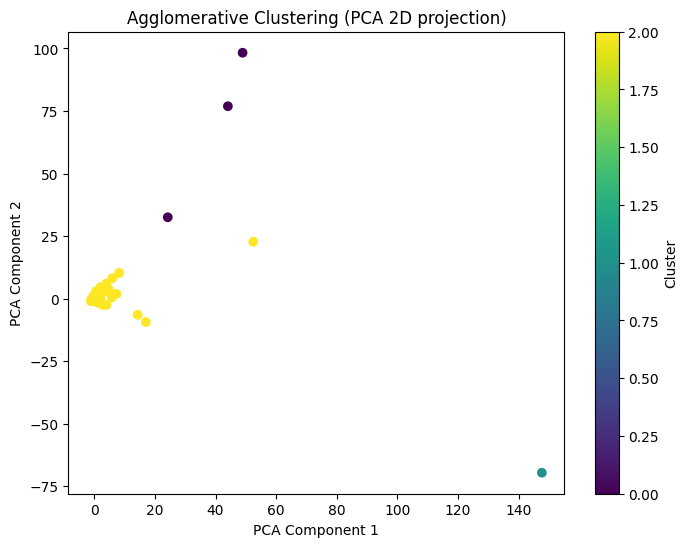

In [63]:
X_dense = X.toarray()

# Standardize the data (important for clustering)
scaler = StandardScaler(with_mean=False)
X_scaled = scaler.fit_transform(X_dense)

# Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=3)  # You can change the number of clusters
y_agg = agg_clustering.fit_predict(X_scaled)

# Plot the results in 2D using PCA (if you want to reduce the dimensions)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Visualizing the clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_agg, cmap='viridis')
plt.title('Agglomerative Clustering (PCA 2D projection)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

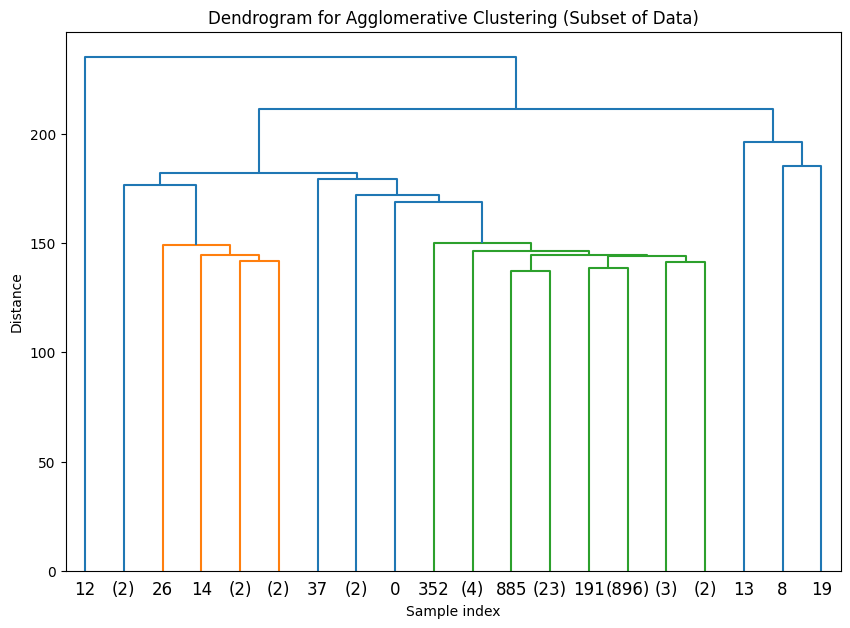

In [64]:

# Sample a subset of your data (for example, 100 data points)
X_sampled = X_scaled[:2000]  # Adjust the number based on your data size

# Compute the linkage matrix
linkage_matrix = sch.linkage(X_sampled, method='ward')  # You can try different methods here

# Create the dendrogram with a cut-off height to limit the number of clusters
plt.figure(figsize=(10, 7))
sch.dendrogram(linkage_matrix, truncate_mode='lastp', p=20)  # 'lastp' keeps the last p merges

# Display the plot
plt.title("Dendrogram for Agglomerative Clustering (Subset of Data)")
plt.xlabel("Sample index")
plt.ylabel("Distance")
plt.show()

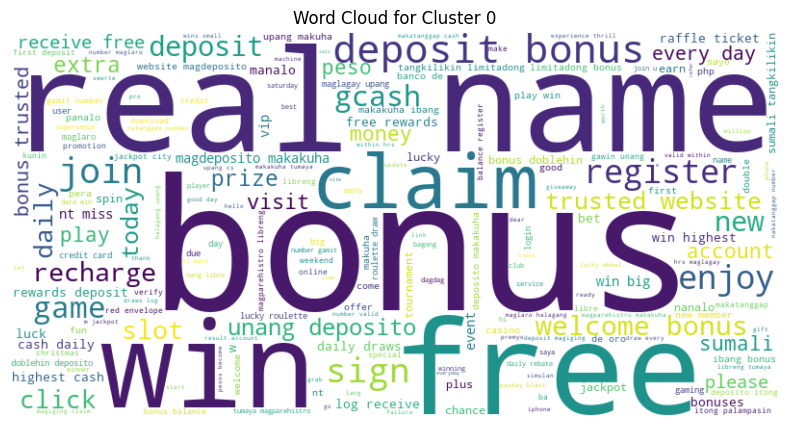

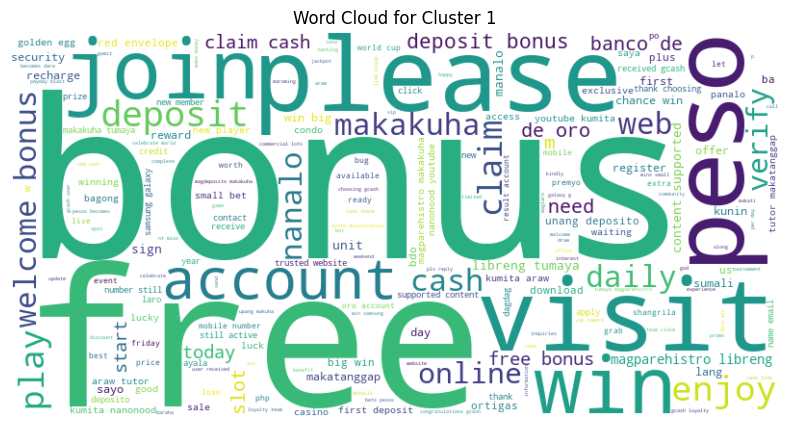

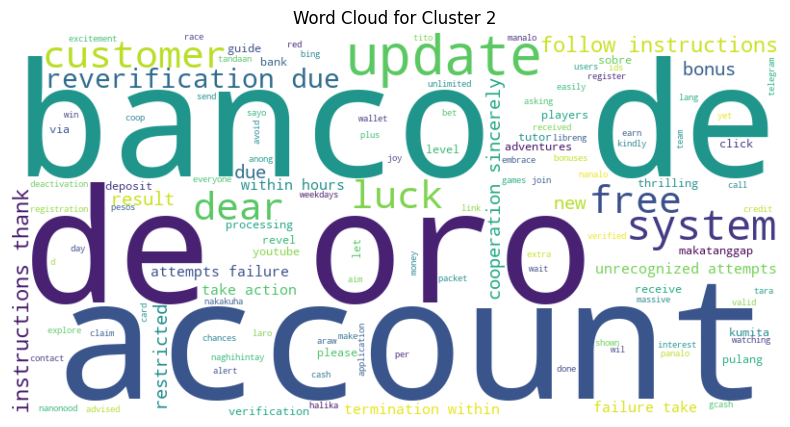

In [ ]:
from wordcloud import WordCloud

k=6

documents = data['cleaned_text'].tolist()

# Step 6: Create a word cloud for each cluster
cluster_texts = {i: [] for i in range(k)}  # Dictionary to store text for each cluster

# Group the documents by their cluster labels
for doc, label in zip(documents, labels):
    cluster_texts[label].append(doc)

# Combine all documents in each cluster into one string
for cluster_id, texts in cluster_texts.items():
    cluster_texts[cluster_id] = " ".join(texts)

# Generate and display a word cloud for each cluster
for cluster_id, cluster_text in cluster_texts.items():
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cluster_text)
    
    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for Cluster {cluster_id}")
    plt.show()


-----------------------------------

In [65]:
documents = data['cleaned_text'].tolist()

# Step 1: Bag of Words (BoW) representation
vectorizer = CountVectorizer()  # Convert text to BoW representation
X_bow = vectorizer.fit_transform(documents)  # Creates a sparse matrix
X_dense = X_bow.toarray()  # Convert sparse matrix to dense format

# Step 2: Agglomerative Hierarchical Clustering
# Using Ward's linkage method
k = 6  # Specify the number of clusters
agg_clustering = AgglomerativeClustering(n_clusters=k, linkage='ward')
labels = agg_clustering.fit_predict(X_dense)

# Step 3: Evaluate clustering with silhouette score
silhouette_avg = silhouette_score(X_dense, labels)
print(f"Silhouette Score: {silhouette_avg}")

# Step 4: Visualization of dendrogram
plt.figure(figsize=(10, 7))
plt.title("Dendrogram (Ward's Linkage)")
dendrogram = sch.dendrogram(sch.linkage(X_dense, method='ward'))
plt.xlabel("Data Points")
plt.ylabel("Euclidean Distance")
plt.show()

# Step 5: Visualize clusters
# Assuming 2D PCA for reducing dimensions (optional, only if you visualize data)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_dense)

plt.figure(figsize=(10, 7))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap='viridis', s=50)
plt.title("Clusters Visualized (Ward's Method)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Cluster Label')
plt.show()

ValueError: np.nan is an invalid document, expected byte or unicode string.

--------------------------

PCA = 3 components,  3D Visualized

Silhouette Score: 0.16260110415084542


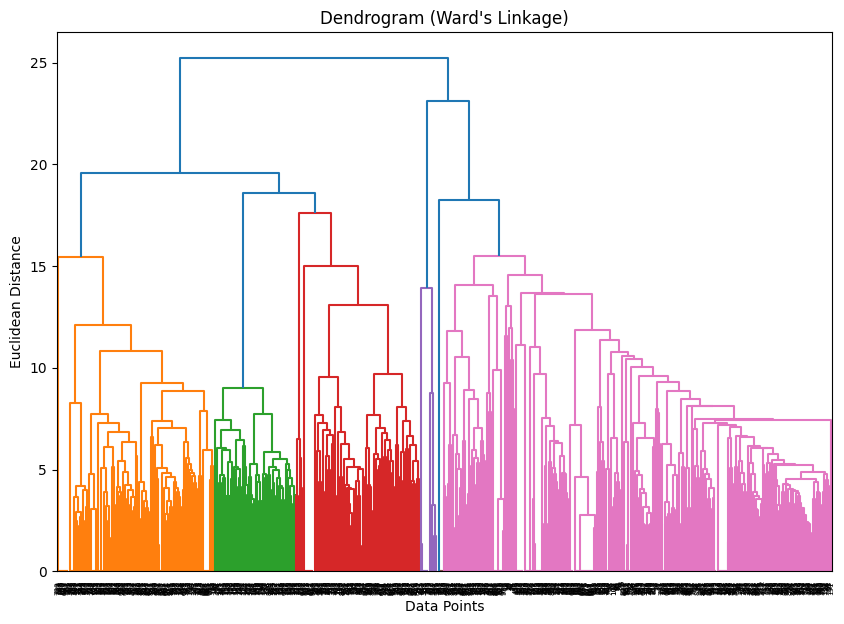

In [91]:
import plotly.express as px
import pandas as pd

# Reduce data to 3D using PCA
pca = PCA(n_components=3)
X_reduced = pca.fit_transform(X_dense)

# Step 2: Agglomerative Hierarchical Clustering
# Using Ward's linkage method
k = 9  # Specify the number of clusters
agg_clustering = AgglomerativeClustering(n_clusters=k, linkage='ward')
labels = agg_clustering.fit_predict(X_dense)

# Step 3: Evaluate clustering with silhouette score
silhouette_avg = silhouette_score(X_reduced, labels)
print(f"Silhouette Score: {silhouette_avg}")

# Step 4: Visualization of dendrogram
plt.figure(figsize=(10, 7))
plt.title("Dendrogram (Ward's Linkage)")
dendrogram = sch.dendrogram(sch.linkage(X_dense, method='ward'))
plt.xlabel("Data Points")
plt.ylabel("Euclidean Distance")
plt.show()


# Trim the documents array to match the length of X_reduced and labels
documents = documents[:len(X_reduced)]

# Now create the DataFrame with the matched lengths
data_visualization = pd.DataFrame({
    'PCA1': X_reduced[:, 0],
    'PCA2': X_reduced[:, 1],
    'PCA3': X_reduced[:, 2],
    'Cluster': labels,
    'Document': documents,  # Add original text for hover
    'Original': X
})


# Create a 3D scatter plot using Plotly
fig = px.scatter_3d(
    data_visualization,
    x='PCA1',
    y='PCA2',
    z='PCA3',
    color='Cluster',
    hover_data={'Document': True, 'Cluster': True},  # Add hover info
    title="Agglomerative Clustering (Interactive 3D Visualization)"
)

# Customize the layout
fig.update_layout(
    scene=dict(
        xaxis_title='PCA Component 1',
        yaxis_title='PCA Component 2',
        zaxis_title='PCA Component 3',
    ),
    coloraxis_colorbar=dict(title="Cluster"),
    margin=dict(l=0, r=0, b=0, t=40)  # Adjust margins
)

# Show the plot
fig.show()


In [67]:
print(f"Shape of the data: {X_dense.shape}")  #(number_of_documents, number_of_features)

Shape of the data: (947, 1545)


In [70]:
print(f"Explained variance by each PCA component: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {sum(pca.explained_variance_ratio_)}")

Explained variance by each PCA component: [0.05403463 0.03601704 0.0304864 ]
Total explained variance: 0.12053806346194794


In [ ]:
for k in range(2, 20):
    clustering = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = clustering.fit_predict(X_reduced)
    silhouette_avg = silhouette_score(X_reduced, labels)
    print(f"Silhouette Score for k={k}: {silhouette_avg}")

Silhouette Score for k=2: 0.5344514648912391
Silhouette Score for k=3: 0.5344514648912391
Silhouette Score for k=4: 0.5344514648912391
Silhouette Score for k=5: 0.5344514648912391
Silhouette Score for k=6: 0.5344514648912391
Silhouette Score for k=7: 0.5344514648912391
Silhouette Score for k=8: 0.5344514648912391
Silhouette Score for k=9: 0.5344514648912391
Silhouette Score for k=10: 0.5344514648912391
Silhouette Score for k=11: 0.5344514648912391
Silhouette Score for k=12: 0.5344514648912391
Silhouette Score for k=13: 0.5344514648912391
Silhouette Score for k=14: 0.5344514648912391
Silhouette Score for k=15: 0.5344514648912391
Silhouette Score for k=16: 0.5344514648912391
Silhouette Score for k=17: 0.5344514648912391
Silhouette Score for k=18: 0.5344514648912391
Silhouette Score for k=19: 0.5344514648912391


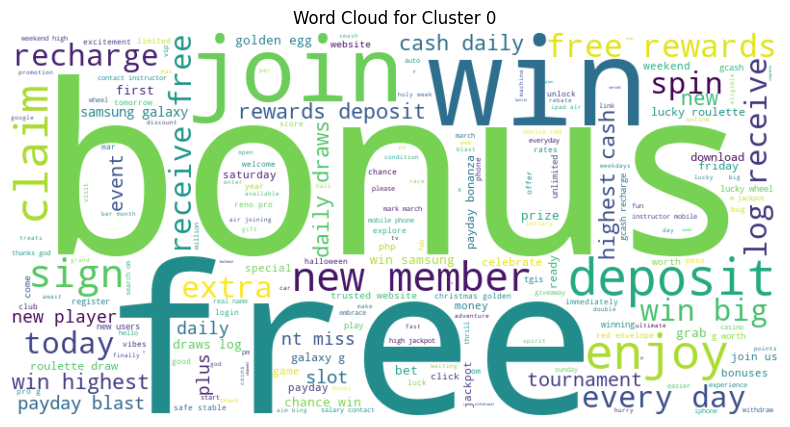

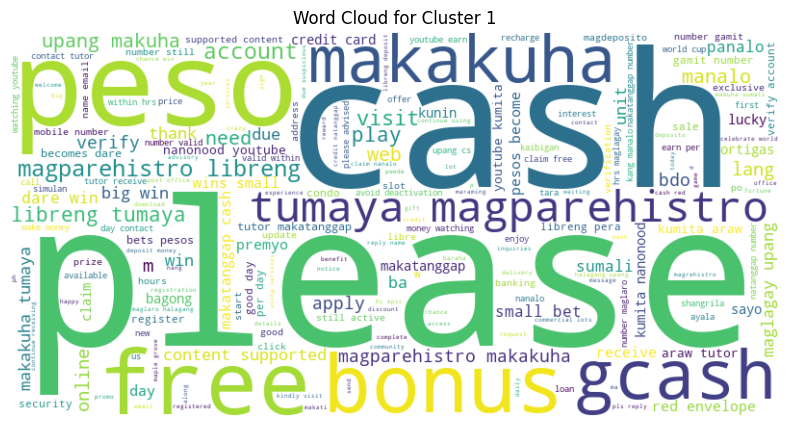

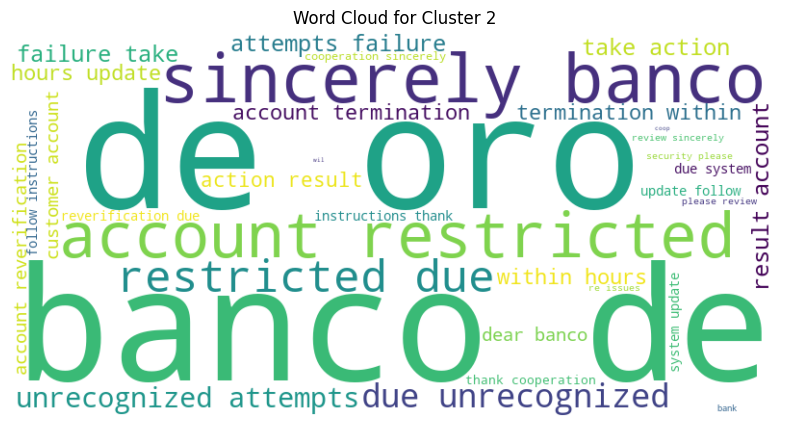

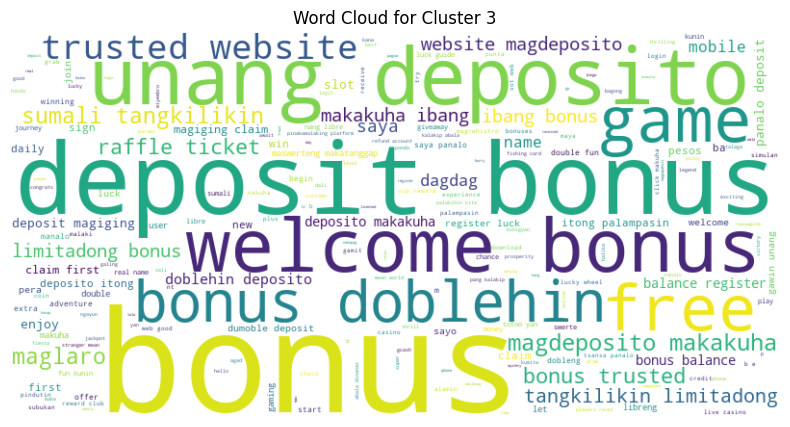

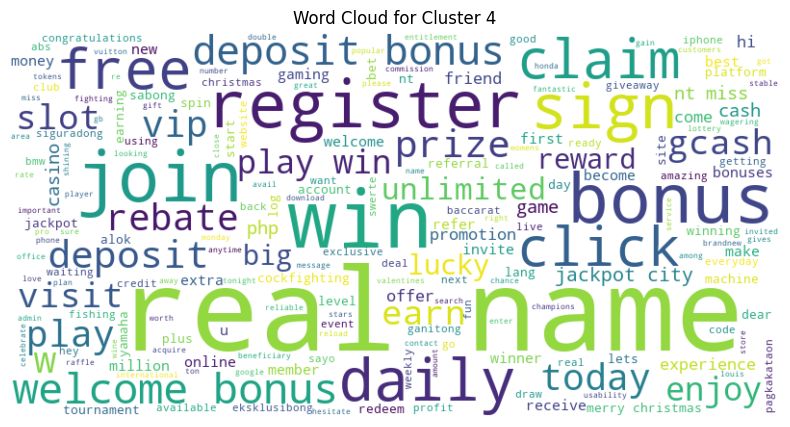

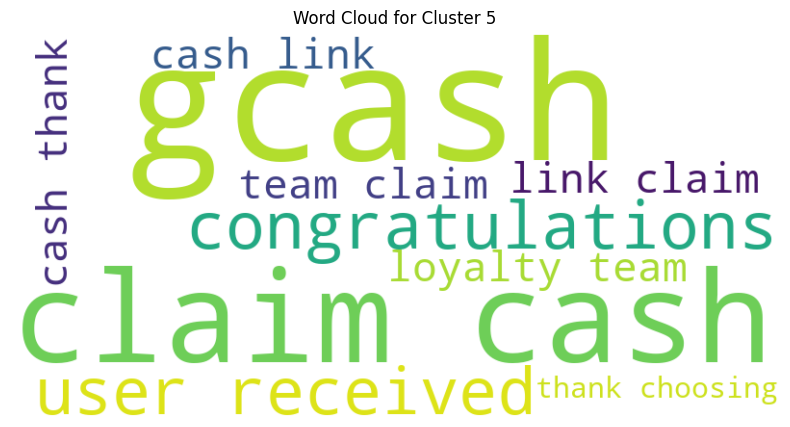

In [114]:
from wordcloud import WordCloud

k=6

# Step 6: Create a word cloud for each cluster
cluster_texts = {i: [] for i in range(k)}  # Dictionary to store text for each cluster

# Group the documents by their cluster labels
for doc, label in zip(documents, labels):
    cluster_texts[label].append(doc)

# Combine all documents in each cluster into one string
for cluster_id, texts in cluster_texts.items():
    cluster_texts[cluster_id] = " ".join(texts)

# Generate and display a word cloud for each cluster
for cluster_id, cluster_text in cluster_texts.items():
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cluster_text)
    
    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for Cluster {cluster_id}")
    plt.show()


-----------------------------

Silhouette Score: 0.07499067884123552


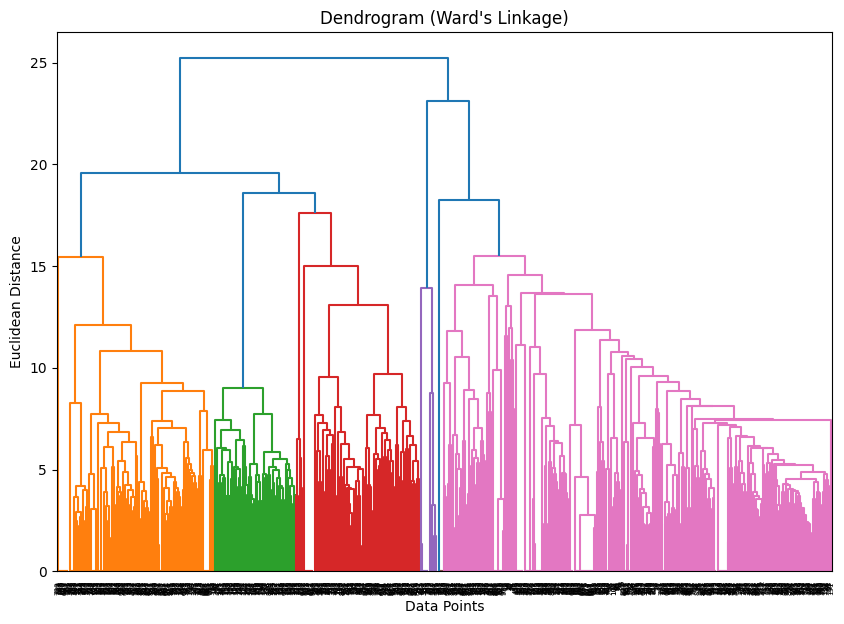

Shape of the data: (947, 1545)
Explained variance by each PCA component: [0.05403463 0.03601704 0.03048643 0.02573269 0.02264304 0.02226879
 0.01791229 0.0169378  0.01451712 0.01391554 0.01324775 0.01289571
 0.0120892  0.01164216 0.01114525 0.01089799 0.01035939 0.01003463
 0.00982042 0.00943581 0.00921611 0.00855042 0.00824033 0.00763532
 0.00754527 0.00731559 0.00721924 0.00712503 0.00693099 0.00679829
 0.00665862 0.00649352 0.00628596 0.00597861 0.00589454 0.00580636
 0.00574632 0.00569773 0.00568433 0.00548361 0.00539404 0.00533014
 0.00529331 0.00513348 0.0049618  0.00484133 0.004811   0.00475037
 0.0047144  0.00461141 0.00452915 0.0043544  0.00425705 0.0042045
 0.00413424 0.00407668 0.00406017 0.0039798  0.00392862 0.0038083 ]
Total explained variance: 0.5935140656013965


In [83]:
import plotly.express as px
import pandas as pd

# Reduce data to 3D using PCA
pca = PCA(n_components=60)
X_reduced = pca.fit_transform(X_dense)

# Step 2: Agglomerative Hierarchical Clustering
# Using Ward's linkage method
k = 9  # Specify the number of clusters
agg_clustering = AgglomerativeClustering(n_clusters=k, linkage='ward')
labels = agg_clustering.fit_predict(X_dense)

# Step 3: Evaluate clustering with silhouette score
silhouette_avg = silhouette_score(X_reduced, labels)
print(f"Silhouette Score: {silhouette_avg}")

# Step 4: Visualization of dendrogram
plt.figure(figsize=(10, 7))
plt.title("Dendrogram (Ward's Linkage)")
dendrogram = sch.dendrogram(sch.linkage(X_dense, method='ward'))
plt.xlabel("Data Points")
plt.ylabel("Euclidean Distance")
plt.show()


# Create a DataFrame to hold the reduced data and labels
data_visualization = pd.DataFrame({
    'PCA1': X_reduced[:, 0],
    'PCA2': X_reduced[:, 1],
    'PCA3': X_reduced[:, 2],
    'Cluster': labels,
    'Document': documents  # Add original text for hover
})

# Create a 3D scatter plot using Plotly
fig = px.scatter_3d(
    data_visualization,
    x='PCA1',
    y='PCA2',
    z='PCA3',
    color='Cluster',
    hover_data={'Document': True, 'Cluster': True},  # Add hover info
    title="Agglomerative Clustering (Interactive 3D Visualization)"
)

# Customize the layout
fig.update_layout(
    scene=dict(
        xaxis_title='PCA Component 1',
        yaxis_title='PCA Component 2',
        zaxis_title='PCA Component 3',
    ),
    coloraxis_colorbar=dict(title="Cluster"),
    margin=dict(l=0, r=0, b=0, t=40)  # Adjust margins
)

# Show the plot
fig.show()

print(f"Shape of the data: {X_dense.shape}")
print(f"Explained variance by each PCA component: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {sum(pca.explained_variance_ratio_)}")



In [54]:
print(pca.components_)  # For PCA, this prints the principal components


[[-0.00098176 -0.00103589  0.00110407 ... -0.02027185 -0.00114527
  -0.00020118]
 [ 0.00355511  0.00019644 -0.00332543 ... -0.00128475  0.00030735
  -0.0009257 ]
 [ 0.0019877  -0.00098965 -0.00173108 ... -0.02266963 -0.00104518
  -0.00044577]
 ...
 [ 0.00347477  0.00202238  0.01276947 ... -0.01863886  0.00130131
   0.00235222]
 [ 0.00217261 -0.00481883  0.00172575 ...  0.01798925 -0.0009281
  -0.00081195]
 [-0.0157911   0.0001366  -0.00247581 ... -0.0141664  -0.01110826
  -0.00119955]]


In [82]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Perform clustering
clustering = AgglomerativeClustering(n_clusters=9, linkage='ward')
labels = clustering.fit_predict(X_reduced)  # Use the reduced data here

# Calculate silhouette score
silhouette_avg = silhouette_score(X_reduced, labels)
print(f"Updated Silhouette Score: {silhouette_avg}")

Updated Silhouette Score: 0.07567591950265377


In [86]:
for k in range(2, 20):
    clustering = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = clustering.fit_predict(X_reduced)
    silhouette_avg = silhouette_score(X_reduced, labels)
    print(f"Silhouette Score for k={k}: {silhouette_avg}")

Silhouette Score for k=2: 0.4312527004559976
Silhouette Score for k=3: 0.47290588578048776
Silhouette Score for k=4: 0.43336239701583495
Silhouette Score for k=5: 0.4753472597428518
Silhouette Score for k=6: 0.4786065095897847
Silhouette Score for k=7: 0.5042398397917606
Silhouette Score for k=8: 0.5127149582749078
Silhouette Score for k=9: 0.5344617573546122
Silhouette Score for k=10: 0.512627775961131
Silhouette Score for k=11: 0.49952637756342727
Silhouette Score for k=12: 0.5046361960256178
Silhouette Score for k=13: 0.5072398626332436
Silhouette Score for k=14: 0.5098715903418684
Silhouette Score for k=15: 0.511012359257573
Silhouette Score for k=16: 0.4711831094440724
Silhouette Score for k=17: 0.47363941323703185
Silhouette Score for k=18: 0.3843702489739983
Silhouette Score for k=19: 0.384818969775394


In [80]:
from wordcloud import WordCloud

k=9

# Step 6: Create a word cloud for each cluster
cluster_texts = {i: [] for i in range(k)}  # Dictionary to store text for each cluster

# Group the documents by their cluster labels
for doc, label in zip(documents, labels):
    cluster_texts[label].append(doc)

# Combine all documents in each cluster into one string
for cluster_id, texts in cluster_texts.items():
    cluster_texts[cluster_id] = " ".join(texts)

# Generate and display a word cloud for each cluster
for cluster_id, cluster_text in cluster_texts.items():
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cluster_text)
    
    # Display the word cloud
    plt.figure(figsize=(6, 3))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for Cluster {cluster_id}")
    plt.show()

KeyError: np.int64(15)

----------------

t-sne

In [93]:
import plotly.express as px
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Step 1: Dimensionality Reduction using t-SNE (3D)
# Using t-SNE for reducing to 3D for better visualization
#tsne = TSNE(n_components=3, random_state=42)
tsne = TSNE(n_components=3, perplexity=20, learning_rate=100, max_iter=2000, random_state=42)
X_tsne = tsne.fit_transform(X_dense)

# Step 2: Agglomerative Hierarchical Clustering
# Specify the number of clusters (can experiment with different values)
k = 7  # You can change this number for experimentation
agg_clustering = AgglomerativeClustering(n_clusters=k, linkage='ward')
labels = agg_clustering.fit_predict(X_dense)

# Step 3: Evaluate clustering with silhouette score
silhouette_avg = silhouette_score(X_dense, labels)
print(f"Silhouette Score: {silhouette_avg}")

# Step 4: Visualization of clusters using 3D t-SNE
# Create a DataFrame to hold the reduced data and labels for plotting
data_visualization = pd.DataFrame({
    'tSNE1': X_tsne[:, 0],
    'tSNE2': X_tsne[:, 1],
    'tSNE3': X_tsne[:, 2],
    'Cluster': labels,
    'Document': documents  # Add original text for hover
})

# Create a 3D scatter plot using Plotly
fig = px.scatter_3d(
    data_visualization,
    x='tSNE1',
    y='tSNE2',
    z='tSNE3',
    color='Cluster',
    hover_data={'Document': True, 'Cluster': True},  # Add hover info
    title="Agglomerative Clustering with 3D t-SNE"
)

# Customize the layout
fig.update_layout(
    coloraxis_colorbar=dict(title="Cluster"),
    margin=dict(l=0, r=0, b=0, t=40)  # Adjust margins
)

# Show the plot
fig.show()


Silhouette Score: 0.02349055979713879


In [95]:
for k in range(2, 20):
    clustering = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = clustering.fit_predict(X_tsne)
    silhouette_avg = silhouette_score(X_tsne, labels)
    print(f"Silhouette Score for k={k}: {silhouette_avg}")

Silhouette Score for k=2: 0.21256054937839508
Silhouette Score for k=3: 0.19532440602779388
Silhouette Score for k=4: 0.19050486385822296
Silhouette Score for k=5: 0.1878848671913147
Silhouette Score for k=6: 0.1968819797039032
Silhouette Score for k=7: 0.20421209931373596
Silhouette Score for k=8: 0.1968817263841629
Silhouette Score for k=9: 0.18297958374023438
Silhouette Score for k=10: 0.17736533284187317
Silhouette Score for k=11: 0.17031635344028473
Silhouette Score for k=12: 0.17631052434444427
Silhouette Score for k=13: 0.1752801090478897
Silhouette Score for k=14: 0.17738457024097443
Silhouette Score for k=15: 0.18296469748020172
Silhouette Score for k=16: 0.1805352121591568
Silhouette Score for k=17: 0.1835261881351471
Silhouette Score for k=18: 0.18487702310085297
Silhouette Score for k=19: 0.1890297830104828


-------------------------------


Silhouette Score: 0.1814662542099074


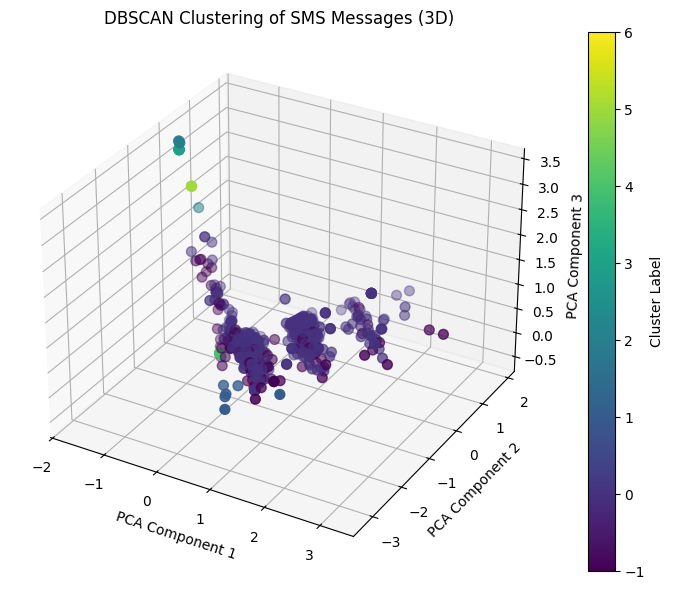

In [ ]:
from sklearn.cluster import DBSCAN

documents = data['cleaned_text'].tolist()

# Step 1: Bag of Words (BoW) representation
vectorizer = CountVectorizer()  # Convert text to BoW representation
X_bow = vectorizer.fit_transform(documents)  # Creates a sparse matrix
X_dense = X_bow.toarray()  # Convert sparse matrix to dense format

# Step 2: DBSCAN Clustering
# DBSCAN does not require n_clusters but requires eps and min_samples
dbscan = DBSCAN(eps=3.5, min_samples=4)  # You can adjust eps and min_samples
labels = dbscan.fit_predict(X_dense)

# Step 3: Evaluate clustering with silhouette score (optional)
# DBSCAN may produce -1 for noise, so we need to ignore it for silhouette score calculation
if len(set(labels)) > 1:  # If there are more than one cluster
    silhouette_avg = silhouette_score(X_dense, labels)
    print(f"Silhouette Score: {silhouette_avg}")
else:
    print("DBSCAN found only one cluster (or noise), silhouette score cannot be calculated.")

# Step 4: Visualization of clusters in 3D
# Use PCA for dimensionality reduction to 3 components
pca = PCA(n_components=3)
X_reduced = pca.fit_transform(X_dense)

# Visualize the clusters in 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for the clusters
scatter = ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=labels, cmap='viridis', s=50)

# Title and axis labels
ax.set_title("DBSCAN Clustering of SMS Messages (3D)")
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")

# Color bar to show the cluster labels
plt.colorbar(scatter, label='Cluster Label')

# Show the plot
plt.show()

Silhouette Score: 0.1814662542099074


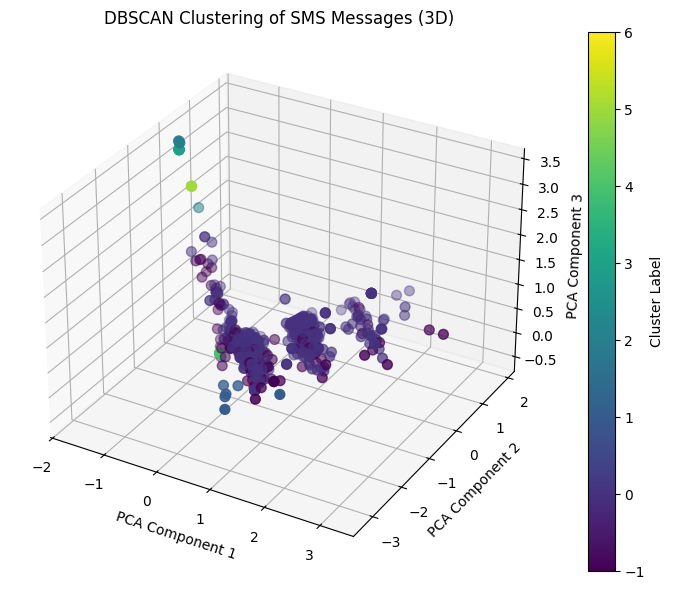

In [ ]:
from sklearn.cluster import DBSCAN

documents = data['cleaned_text'].tolist()

# Step 1: Bag of Words (BoW) representation
vectorizer = CountVectorizer()  # Convert text to BoW representation
X_bow = vectorizer.fit_transform(documents)  # Creates a sparse matrix
X_dense = X_bow.toarray()  # Convert sparse matrix to dense format

# Step 2: DBSCAN Clustering
# DBSCAN does not require n_clusters but requires eps and min_samples
dbscan = DBSCAN(eps=3.5, min_samples=4)  # You can adjust eps and min_samples
labels = dbscan.fit_predict(X_dense)

# Step 3: Evaluate clustering with silhouette score (optional)
# DBSCAN may produce -1 for noise, so we need to ignore it for silhouette score calculation
if len(set(labels)) > 1:  # If there are more than one cluster
    silhouette_avg = silhouette_score(X_dense, labels)
    print(f"Silhouette Score: {silhouette_avg}")
else:
    print("DBSCAN found only one cluster (or noise), silhouette score cannot be calculated.")

# Step 4: Visualization of clusters in 3D
# Use PCA for dimensionality reduction to 3 components
pca = PCA(n_components=3)
X_reduced = pca.fit_transform(X_dense)

# Visualize the clusters in 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for the clusters
scatter = ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=labels, cmap='viridis', s=50)

# Title and axis labels
ax.set_title("DBSCAN Clustering of SMS Messages (3D)")
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")

# Color bar to show the cluster labels
plt.colorbar(scatter, label='Cluster Label')

# Show the plot
plt.show()

Silhouette Score: 0.1814662542099074


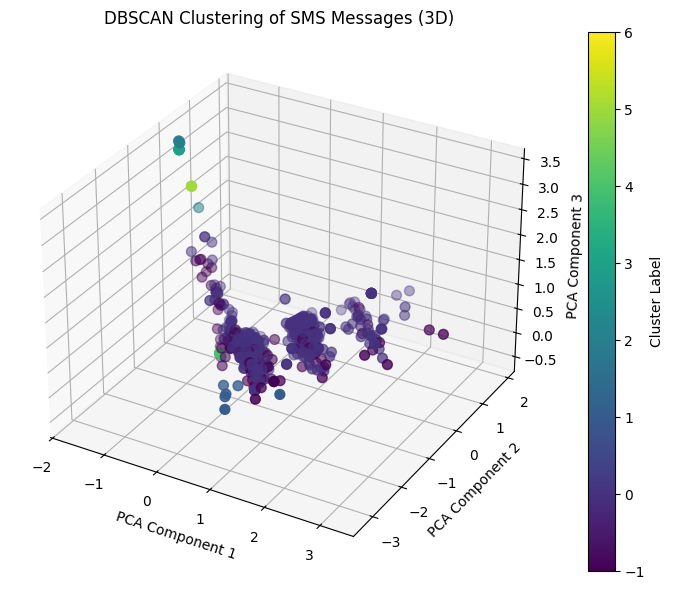

In [109]:
from sklearn.cluster import DBSCAN

documents = data['cleaned_text'].tolist()

# Step 1: Bag of Words (BoW) representation
vectorizer = CountVectorizer()  # Convert text to BoW representation
X_bow = vectorizer.fit_transform(documents)  # Creates a sparse matrix
X_dense = X_bow.toarray()  # Convert sparse matrix to dense format

# Step 2: DBSCAN Clustering
# DBSCAN does not require n_clusters but requires eps and min_samples
dbscan = DBSCAN(eps=3.5, min_samples=4)  # You can adjust eps and min_samples
labels = dbscan.fit_predict(X_dense)

# Step 3: Evaluate clustering with silhouette score (optional)
# DBSCAN may produce -1 for noise, so we need to ignore it for silhouette score calculation
if len(set(labels)) > 1:  # If there are more than one cluster
    silhouette_avg = silhouette_score(X_dense, labels)
    print(f"Silhouette Score: {silhouette_avg}")
else:
    print("DBSCAN found only one cluster (or noise), silhouette score cannot be calculated.")

# Step 4: Visualization of clusters in 3D
# Use PCA for dimensionality reduction to 3 components
pca = PCA(n_components=3)
X_reduced = pca.fit_transform(X_dense)

# Visualize the clusters in 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for the clusters
scatter = ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=labels, cmap='viridis', s=50)

# Title and axis labels
ax.set_title("DBSCAN Clustering of SMS Messages (3D)")
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")

# Color bar to show the cluster labels
plt.colorbar(scatter, label='Cluster Label')

# Show the plot
plt.show()

Silhouette Score: 0.1814662542099074


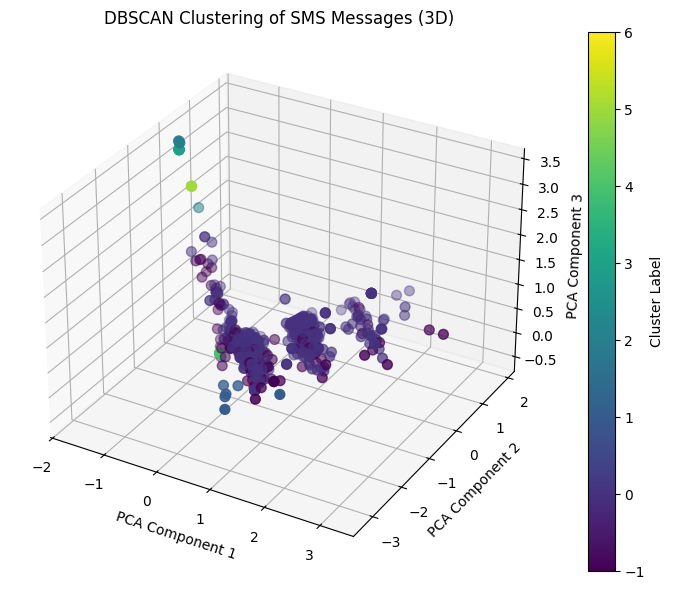

In [ ]:
from sklearn.cluster import DBSCAN

documents = data['cleaned_text'].tolist()

# Step 1: Bag of Words (BoW) representation
vectorizer = CountVectorizer()  # Convert text to BoW representation
X_bow = vectorizer.fit_transform(documents)  # Creates a sparse matrix
X_dense = X_bow.toarray()  # Convert sparse matrix to dense format

# Step 2: DBSCAN Clustering
# DBSCAN does not require n_clusters but requires eps and min_samples
dbscan = DBSCAN(eps=3.5, min_samples=4)  # You can adjust eps and min_samples
labels = dbscan.fit_predict(X_dense)

# Step 3: Evaluate clustering with silhouette score (optional)
# DBSCAN may produce -1 for noise, so we need to ignore it for silhouette score calculation
if len(set(labels)) > 1:  # If there are more than one cluster
    silhouette_avg = silhouette_score(X_dense, labels)
    print(f"Silhouette Score: {silhouette_avg}")
else:
    print("DBSCAN found only one cluster (or noise), silhouette score cannot be calculated.")

# Step 4: Visualization of clusters in 3D
# Use PCA for dimensionality reduction to 3 components
pca = PCA(n_components=3)
X_reduced = pca.fit_transform(X_dense)

# Visualize the clusters in 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for the clusters
scatter = ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=labels, cmap='viridis', s=50)

# Title and axis labels
ax.set_title("DBSCAN Clustering of SMS Messages (3D)")
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")

# Color bar to show the cluster labels
plt.colorbar(scatter, label='Cluster Label')

# Show the plot
plt.show()

Silhouette Score: 0.1814662542099074


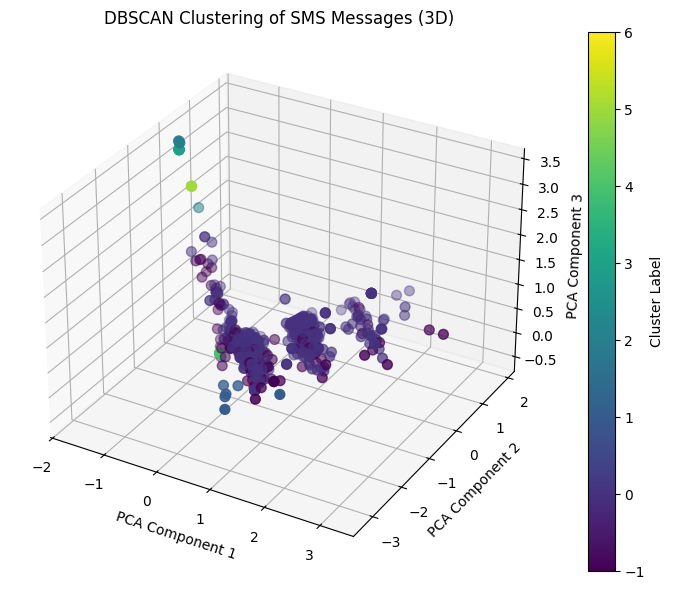

In [ ]:
from sklearn.cluster import DBSCAN

documents = data['cleaned_text'].tolist()

# Step 1: Bag of Words (BoW) representation
vectorizer = CountVectorizer()  # Convert text to BoW representation
X_bow = vectorizer.fit_transform(documents)  # Creates a sparse matrix
X_dense = X_bow.toarray()  # Convert sparse matrix to dense format

# Step 2: DBSCAN Clustering
# DBSCAN does not require n_clusters but requires eps and min_samples
dbscan = DBSCAN(eps=3.5, min_samples=4)  # You can adjust eps and min_samples
labels = dbscan.fit_predict(X_dense)

# Step 3: Evaluate clustering with silhouette score (optional)
# DBSCAN may produce -1 for noise, so we need to ignore it for silhouette score calculation
if len(set(labels)) > 1:  # If there are more than one cluster
    silhouette_avg = silhouette_score(X_dense, labels)
    print(f"Silhouette Score: {silhouette_avg}")
else:
    print("DBSCAN found only one cluster (or noise), silhouette score cannot be calculated.")

# Step 4: Visualization of clusters in 3D
# Use PCA for dimensionality reduction to 3 components
pca = PCA(n_components=3)
X_reduced = pca.fit_transform(X_dense)

# Visualize the clusters in 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for the clusters
scatter = ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=labels, cmap='viridis', s=50)

# Title and axis labels
ax.set_title("DBSCAN Clustering of SMS Messages (3D)")
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")

# Color bar to show the cluster labels
plt.colorbar(scatter, label='Cluster Label')

# Show the plot
plt.show()

Silhouette Score: 0.1814662542099074


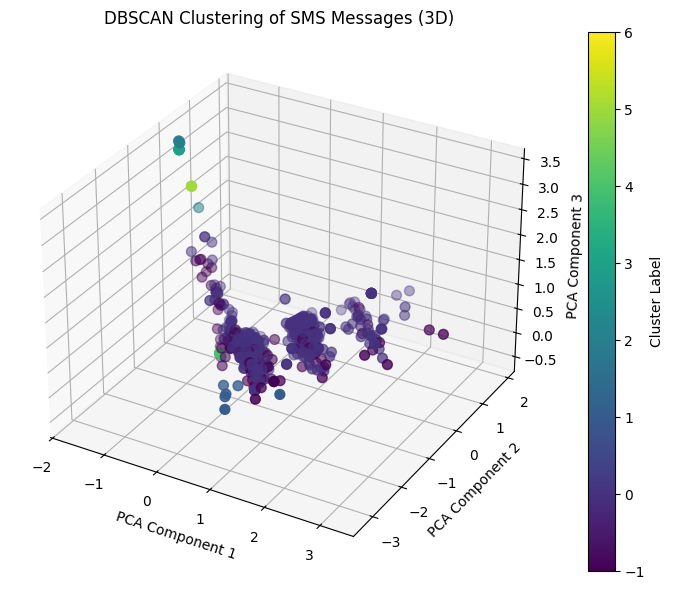

In [ ]:
from sklearn.cluster import DBSCAN

documents = data['cleaned_text'].tolist()

# Step 1: Bag of Words (BoW) representation
vectorizer = CountVectorizer()  # Convert text to BoW representation
X_bow = vectorizer.fit_transform(documents)  # Creates a sparse matrix
X_dense = X_bow.toarray()  # Convert sparse matrix to dense format

# Step 2: DBSCAN Clustering
# DBSCAN does not require n_clusters but requires eps and min_samples
dbscan = DBSCAN(eps=3.5, min_samples=4)  # You can adjust eps and min_samples
labels = dbscan.fit_predict(X_dense)

# Step 3: Evaluate clustering with silhouette score (optional)
# DBSCAN may produce -1 for noise, so we need to ignore it for silhouette score calculation
if len(set(labels)) > 1:  # If there are more than one cluster
    silhouette_avg = silhouette_score(X_dense, labels)
    print(f"Silhouette Score: {silhouette_avg}")
else:
    print("DBSCAN found only one cluster (or noise), silhouette score cannot be calculated.")

# Step 4: Visualization of clusters in 3D
# Use PCA for dimensionality reduction to 3 components
pca = PCA(n_components=3)
X_reduced = pca.fit_transform(X_dense)

# Visualize the clusters in 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for the clusters
scatter = ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=labels, cmap='viridis', s=50)

# Title and axis labels
ax.set_title("DBSCAN Clustering of SMS Messages (3D)")
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")

# Color bar to show the cluster labels
plt.colorbar(scatter, label='Cluster Label')

# Show the plot
plt.show()

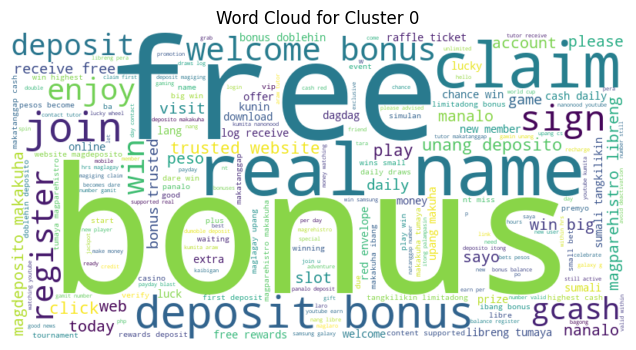

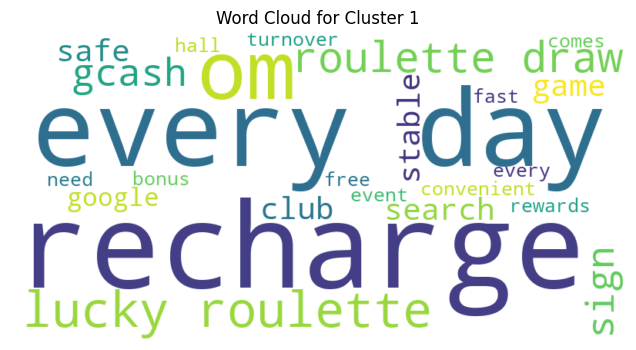

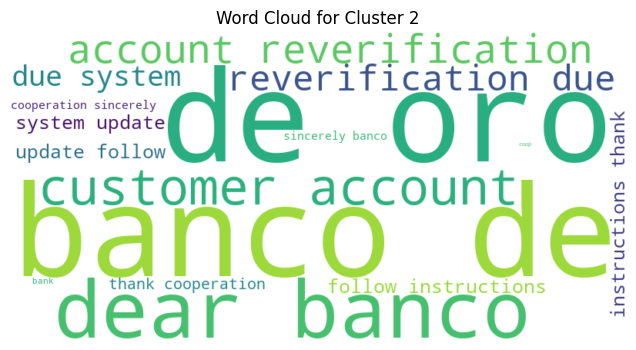

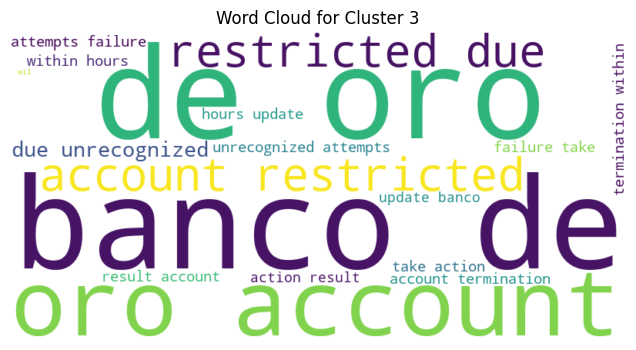

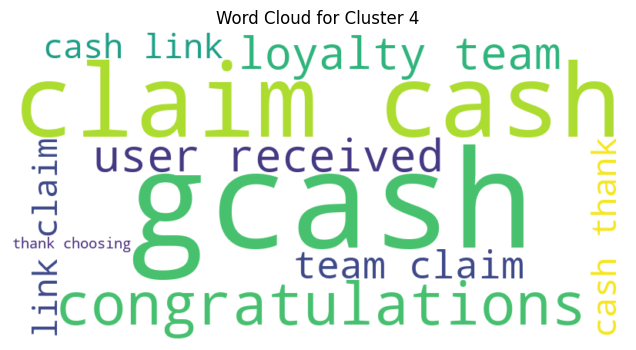

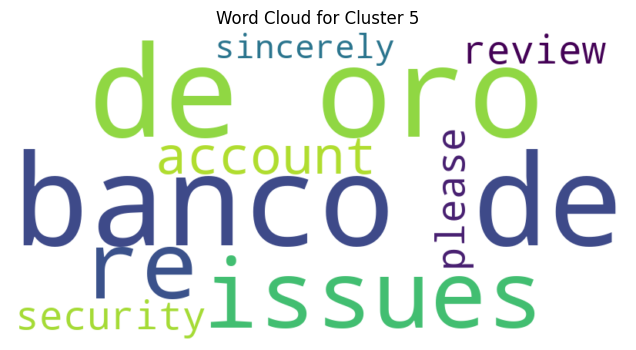

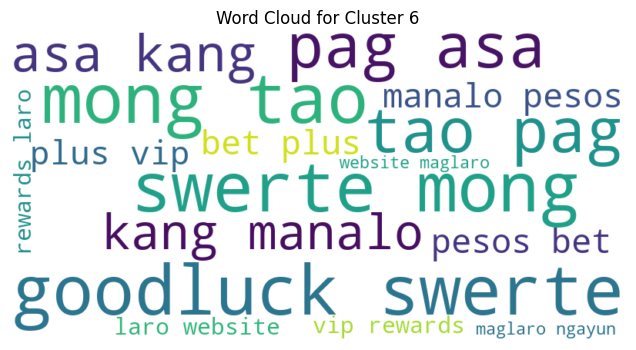

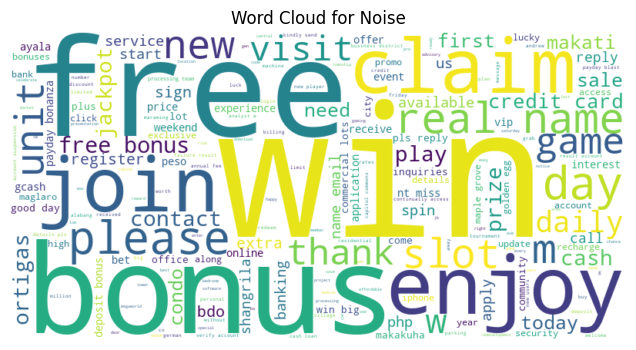

In [110]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Step 6: Create a word cloud for each cluster (including noise)
# Get the unique cluster labels (including noise labeled as -1)
unique_labels = set(labels)

# Initialize a dictionary to store texts for each cluster
cluster_texts = {label: [] for label in unique_labels}

# Group the documents by their cluster labels
for doc, label in zip(documents, labels):
    cluster_texts[label].append(doc)

# Generate and display a word cloud for each cluster
for cluster_id, cluster_text in cluster_texts.items():
    # Combine all documents in each cluster into one string
    cluster_text = " ".join(cluster_text)
    
    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cluster_text)
    
    # Display the word cloud
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for Cluster {cluster_id}" if cluster_id != -1 else "Word Cloud for Noise")
    plt.show()
